In [3154]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator
from sklearn.metrics import ndcg_score

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [3155]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)

df = df.dropna(subset=['relative_quarterly_return'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14322 entries, 1 to 15338
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           14322 non-null  int64         
 1   datadate                        14322 non-null  datetime64[ns]
 2   tic                             14322 non-null  object        
 3   actq                            14322 non-null  float64       
 4   ancq                            14322 non-null  float64       
 5   epsfxq                          14302 non-null  float64       
 6   lctq                            14322 non-null  float64       
 7   ltq                             14322 non-null  float64       
 8   revtq                           14322 non-null  float64       
 9   capxy                           13783 non-null  float64       
 10  roa                             14289 non-null  float64       
 11  ro

In [3156]:
drop_features = ['capxy', 'cfm', 'PEG_trailing', 'de_ratio', 'divyield']
df = df.drop(drop_features, 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 32 to 15337
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non-null  float64       
 11  p

In [3157]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 80
['AAPL' 'ABT' 'ADBE' 'ADM' 'AMD' 'AMGN' 'AMT' 'AMZN' 'APD' 'BA' 'BAX'
 'BMY' 'CAT' 'CL' 'CME' 'COP' 'COST' 'CSCO' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL'
 'EQIX' 'EXC' 'EXPE' 'F' 'FDX' 'FIS' 'GE' 'GOOGL' 'HCA' 'HD' 'IBM' 'INTC'
 'JBL' 'JNJ' 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'META' 'MMC' 'MMM'
 'MRK' 'MSFT' 'MU' 'NFLX' 'NKE' 'NOC' 'NVDA' 'OXY' 'PFE' 'PG' 'PPL' 'PYPL'
 'QCOM' 'REGN' 'RJF' 'RTX' 'SBUX' 'SPGI' 'STZ' 'T' 'TGT' 'TMO' 'TSLA'
 'TSN' 'UNH' 'UPS' 'V' 'VZ' 'WBA' 'WDC' 'WMT' 'XOM' 'ZTS']


In [3158]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.info()

Number of unique gvkeys: 80
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 172 to 3737
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non

In [3159]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

df = df[~df['tic'].isin(tickers_to_drop)]
df = df.sort_values(by=['datadate'])

In [3160]:
#df['next_relative_quarterly_return'] = df.groupby("datadate")["next_relative_quarterly_return"].rank(ascending=False, method="first")
df = df.sort_values(by=['datadate', 'next_relative_quarterly_return'], ascending=[True, False])

df.head()

,gvkey,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,roa,...,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return,spindx,spindx_change,next_spindx_change,prccq,prccq_change,next_prccq_change
3271,8549,1970-03-31,COP,0.0,0.0,-0.122449,0.0,0.0,-0.024939,0.131,...,0.0,0.074219,-0.004692,0.247488,89.63,-0.026396,-0.188665,23.374998,-0.031088,0.058823
5213,4839,1970-03-31,F,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,...,0.0,-0.005464,0.138857,0.147681,89.63,-0.026396,-0.188665,45.749946,0.112462,-0.040983
15082,4503,1970-03-31,XOM,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,...,0.0,0.050788,-0.046479,0.144996,89.63,-0.026396,-0.188665,57.250000,-0.072874,-0.043668
5679,5047,1970-03-31,GE,0.0,0.0,0.000000,0.0,0.0,-0.194418,0.144,...,0.0,-0.058690,-0.021991,0.103919,89.63,-0.026396,-0.188665,73.749939,-0.048387,-0.084746
4054,2991,1970-03-31,CVX,0.0,0.0,-0.089552,0.0,0.0,0.028004,0.110,...,0.0,-0.084615,-0.103189,0.093159,89.63,-0.026396,-0.188665,44.500000,-0.129584,-0.095506


In [3161]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

valid_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 10188 to 12834
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           789 non-null    int64         
 1   datadate                        789 non-null    datetime64[ns]
 2   tic                             789 non-null    object        
 3   actq                            789 non-null    float64       
 4   ancq                            789 non-null    float64       
 5   epsfxq                          789 non-null    float64       
 6   lctq                            789 non-null    float64       
 7   ltq                             789 non-null    float64       
 8   revtq                           789 non-null    float64       
 9   roa                             789 non-null    float64       
 10  roe                             789 non-null    float64       
 11  

In [3162]:
# for ranking
train_group = list(train_df['datadate'].value_counts().sort_index().tolist())
valid_group = list(valid_df['datadate'].value_counts().sort_index().tolist())
test_group = list(test_df['datadate'].value_counts().sort_index().tolist())

print(train_group)

[27, 29, 31, 30, 32, 33, 35, 32, 32, 32, 34, 30, 31, 35, 36, 35, 38, 37, 38, 37, 39, 39, 36, 36, 37, 35, 37, 37, 34, 34, 37, 39, 37, 38, 38, 38, 38, 38, 40, 40, 39, 39, 34, 32, 35, 37, 38, 34, 40, 43, 41, 36, 37, 34, 36, 39, 42, 43, 44, 46, 48, 46, 47, 48, 41, 40, 48, 49, 44, 40, 45, 46, 47, 51, 52, 51, 48, 48, 49, 49, 46, 42, 48, 50, 47, 47, 53, 50, 43, 43, 49, 53, 50, 47, 53, 51, 48, 50, 55, 53, 51, 48, 48, 51, 50, 49, 49, 48, 43, 40, 46, 48, 45, 45, 51, 47, 42, 47, 51, 51, 53, 51, 53, 56, 52, 52, 56, 57, 58, 57, 58, 59, 59, 59, 60, 61, 56, 56, 60, 60, 52, 51, 56, 58, 59, 59, 61, 61, 60, 60, 62, 63, 62, 63, 65, 65, 64, 65, 66, 66]


In [3163]:
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

drop_cols = ['gvkey', 'spindx', 'spindx_change', 'next_spindx_change', 'prccq', 'prccq_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,...,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return,next_prccq_change
3271,1970-03-31,COP,0.0,0.0,-0.122449,0.0,0.0,-0.024939,0.131,-0.007,...,-0.086275,-0.020408,-0.017241,0.000000,0.0,0.0,0.074219,-0.004692,0.247488,0.058823
5213,1970-03-31,F,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,...,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857,0.147681,-0.040983
15082,1970-03-31,XOM,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,...,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479,0.144996,-0.043668
5679,1970-03-31,GE,0.0,0.0,0.000000,0.0,0.0,-0.194418,0.144,0.062,...,0.000000,0.000000,-0.393939,0.000000,0.0,0.0,-0.058690,-0.021991,0.103919,-0.084746
4054,1970-03-31,CVX,0.0,0.0,-0.089552,0.0,0.0,0.028004,0.110,0.020,...,0.015542,-0.025000,-0.042017,0.043961,0.0,0.0,-0.084615,-0.103189,0.093159,-0.095506


In [3164]:
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['datadate', 'tic', 'next_relative_quarterly_return', 'next_prccq_change'], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['datadate', 'tic', 'next_relative_quarterly_return', 'next_prccq_change'], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['datadate', 'tic', 'next_relative_quarterly_return', 'next_prccq_change'], 1)

X_train.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
3271,0.0,0.0,-0.122449,0.0,0.0,-0.024939,0.131,-0.007,14.655,5.818,...,-0.079099,0.036667,-0.086275,-0.020408,-0.017241,0.000000,0.0,0.0,0.074219,-0.004692
5213,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,9.079,3.284,...,0.371212,0.000000,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857
15082,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,11.749,6.020,...,-0.000895,0.000000,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479
5679,0.0,0.0,0.000000,0.0,0.0,-0.194418,0.144,0.062,21.621,7.412,...,0.000000,0.000000,0.000000,0.000000,-0.393939,0.000000,0.0,0.0,-0.058690,-0.021991
4054,0.0,0.0,-0.089552,0.0,0.0,0.028004,0.110,0.020,8.317,4.854,...,0.016043,0.000000,0.015542,-0.025000,-0.042017,0.043961,0.0,0.0,-0.084615,-0.103189


In [3165]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
0,0.15915,0.15647,0.600333,0.14011,0.103656,0.084321,0.784266,0.300878,0.557548,0.461337,...,0.305257,0.282861,0.504882,0.543146,0.892838,0.114721,0.075733,0.263092,0.029858,0.118900
1,0.15915,0.15647,0.600278,0.14011,0.103656,0.070774,0.808472,0.301376,0.554554,0.457561,...,0.307639,0.282770,0.508806,0.538162,0.892708,0.114771,0.075733,0.263092,0.027439,0.142569
2,0.15915,0.15647,0.600801,0.14011,0.103656,0.089930,0.796067,0.301351,0.555988,0.461638,...,0.305671,0.282770,0.505401,0.541744,0.892514,0.114802,0.075733,0.263092,0.029147,0.112010
3,0.15915,0.15647,0.600858,0.14011,0.103656,0.068736,0.788200,0.301715,0.561289,0.463713,...,0.305676,0.282770,0.505650,0.543478,0.891501,0.114721,0.075733,0.263092,0.025824,0.116047
4,0.15915,0.15647,0.600474,0.14011,0.103656,0.089189,0.777912,0.301206,0.554144,0.459900,...,0.305761,0.282770,0.505789,0.543071,0.892750,0.114736,0.075733,0.263092,0.025037,0.102659


In [3166]:
# **Define Model Parameters**
model = xgb.XGBRanker(
    objective="rank:ndcg",
    eval_metric="ndcg@10",
    ndcg_exp_gain=False,
    learning_rate=0.05,
    max_depth=8,  # Reduce to avoid overfitting
    gamma=0.1,  # Increase regularization
    random_state=42,
    n_estimators=300
)

model.fit(
        X_train_scaled,
        y_train,
        group=train_group,
        verbose=True,
    )


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric='ndcg@10', feature_types=None, gamma=0.1,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.05, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=300,
          n_jobs=None, ndcg_exp_gain=False, num_parallel_tree=None, ...)

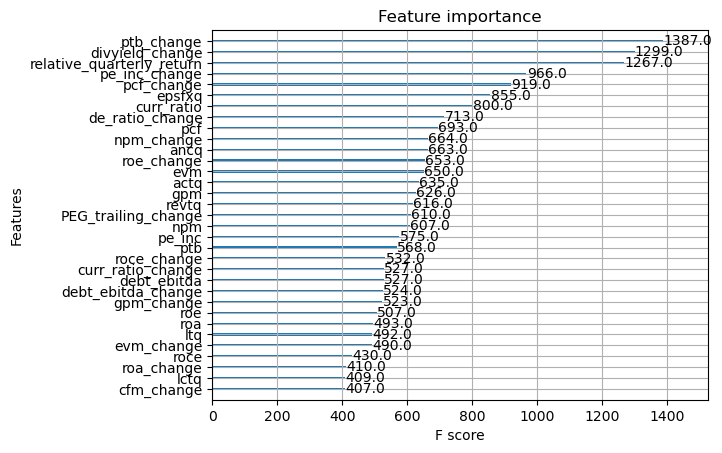

In [3167]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [3168]:
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)


# Convert test predictions into a DataFrame
predictions_df = pd.DataFrame({"datadate": test_df["datadate"], "tic": test_df["tic"], "true_relative_return": y_test, "pred_rank_score": y_test_pred, 'real_return': test_df['next_prccq_change']})

# Rank stocks within each datadate
predictions_df["pred_rank"] = predictions_df.groupby("datadate")["pred_rank_score"].rank(ascending=False, method="first")
predictions_df["true_rank"] = predictions_df.groupby("datadate")["real_return"].rank(ascending=False, method="first")

#predictions_df = predictions_df.sort_values(by=["datadate", "pred_rank_score"], ascending=[True, True])

# Show the selected stocks for portfolio construction


In [3169]:
predictions_df = predictions_df.sort_values(by=["datadate", "real_return"], ascending=[True, False])
predictions_df.head(10)

,datadate,tic,true_relative_return,pred_rank_score,real_return,pred_rank,true_rank
1253,2013-03-31,AMD,0.566207,3.611665,0.600000,1.0,1.0
10115,2013-03-31,MU,0.318003,2.073404,0.394627,2.0,2.0
11978,2013-03-31,REGN,0.241016,1.891009,0.274808,3.0,3.0
3228,2013-03-31,CME,0.202977,-0.003631,0.236769,26.0,4.0
14621,2013-03-31,WDC,0.200846,1.531590,0.234639,5.0,5.0
9959,2013-03-31,MSFT,0.173863,1.095823,0.207656,7.0,6.0
13004,2013-03-31,STZ,0.121613,1.802685,0.198237,4.0,7.0
2121,2013-03-31,BA,0.159451,0.700274,0.193244,10.0,8.0
10580,2013-03-31,NOC,0.146535,1.001797,0.180328,8.0,9.0
13375,2013-03-31,TGT,0.101628,0.458533,0.168019,14.0,10.0


In [3170]:
# Group by 'datadate' and calculate the count of rows and the mean of 'next_prccq_change'
df_avg = predictions_df.groupby('datadate').agg(
    stocks=('real_return', 'size'),
    baseline=('real_return', 'mean')
).reset_index()


# Add a 'top_10' column that contains the average of the top 10 highest 'y_pred' for each quarter
df_avg['top_10'] = predictions_df.groupby('datadate').apply(
    lambda x: x.nlargest(10, 'pred_rank_score')['real_return'].mean()
).reset_index(level=0, drop=True)


df_avg['top_10_ideal'] = predictions_df.groupby('datadate').apply(
    lambda x: x.nlargest(10, 'real_return')['real_return'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10'] = predictions_df.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'pred_rank_score')['real_return'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10_ideal'] = predictions_df.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'real_return')['real_return'].mean()
).reset_index(level=0, drop=True)

# Show the first few rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,63,0.065437,0.248852,0.268833,-0.032913,-0.084238
1,2013-06-30,64,0.059808,0.141755,0.230842,-0.009824,-0.061988
2,2013-09-30,66,0.110123,0.245315,0.314411,-0.022591,-0.058148
3,2013-12-31,66,0.032754,0.104179,0.183728,-0.019660,-0.082451
4,2014-03-31,66,0.039382,0.085457,0.158701,0.020349,-0.061300
5,2014-06-30,67,0.022670,0.092796,0.167058,-0.052132,-0.099601
6,2014-09-30,65,0.054048,0.170130,0.196296,-0.023824,-0.109057
7,2014-12-31,64,0.027150,0.129935,0.177872,-0.087767,-0.122243
8,2015-03-31,65,0.009599,0.112749,0.175274,-0.054937,-0.111613
9,2015-06-30,63,-0.056546,0.055590,0.096890,-0.147528,-0.220885


In [3171]:
for portfolio in ['baseline', 'top_10', 'bottom_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.03360167684373077
Sharpe Ratio of the baseline portfolio: 0.14378314191983466

Mean quarterly return of the top_10 portfolio: 0.1536894006939014
Sharpe Ratio of the top_10 portfolio: 1.5927965747301391

Mean quarterly return of the bottom_10 portfolio: -0.07236767685948291
Sharpe Ratio of the bottom_10 portfolio: -1.320780141349857



In [3172]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()
